# Replicate the CERES model

## The CERES model

The following is the CERES model as desicrbed in ["Computational correction of copy number effect improves specificity of CRISPR–Cas9 essentiality screens in cancer cells"](https://www.nature.com/articles/ng.3984#Sec24) (Meyeres *et al*, 2017).


$
\quad D_{ij} = q_i \lgroup \sum_{k \in G_i} (h_k + g_{kj}) + \mathcal{f} (\sum_{l \in L_i} C_{lj}) \rgroup + o_i + \epsilon
$

where:

- $D_{ij}$: sgRNA $i$ depletion in cell line $j$
- $q_i$: "guide activity score... to mitigate the influence of low-quality reagents" (restricted $[0,1]$)
- $G_i$: the genes targeted by sgRNA $i$
- $h_k$: "shared" (non-cell-line-specific) effect of gene $k$
- $g_{kj}$: cell-line-specific effect in cell line $j$ and gene $k$
- $\mathcal{f}_j$: piecewise linear spine to model copy number effect
- $L_i$: target loci of sgRNA $i$
- $C_{lj}$: copy number of target locus $l$ in cell line $j$
- $o_i$: sgRNA-sepcific effect to account for noise in the measurement of sgRNA abundance in the reference pool
- $\epsilon$: normal error

### Notebook goal

Here I will build three models: (1) without a CN covariate, (2) with a standard linear covariate for copy number, and (3) with a spline function for the CNA covariate.
In this notebook, the models will be run with a subsample of the data, but they will eventually be turned into Python scripts to run on the full data set.

### Set-up

In [1]:
import string
import warnings
from pathlib import Path

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_helpers as pmhelp
import seaborn as sns
from theano import tensor as tt

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())

%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

### Data preparation

In [2]:
data_path = Path("../modeling_data/depmap_modeling_dataframe_subsample.csv")
data = pd.read_csv(data_path)
data.head(n=7)

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,log2_gene_cn_p1,gene_cn,n_muts,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr
0,AAGAGGCCGGTCAAATTCAG,42-mg-ba-311cas9_repa_p6_batch3,-0.405499,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.845287,1.328646,0,False,NaN,NaN,NaN,NaN,False,1.263034
1,AATCAACCCACAGCTGCACA,42-mg-ba-311cas9_repa_p6_batch3,-0.133541,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.827398,1.287359,2,False,missense_mutation;missense_mutation,FALSE;FALSE,TRUE;TRUE,TRUE;TRUE,False,5.220330
2,AATTACTACTTGCTTCCTGT,42-mg-ba-311cas9_repa_p6_batch3,-0.491495,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.879280,1.409165,0,False,NaN,NaN,NaN,NaN,False,3.008989
3,ACCTGTATGACGAAACCGTG,42-mg-ba-311cas9_repa_p6_batch3,-0.015850,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.818549,1.267208,0,False,NaN,NaN,NaN,NaN,False,4.083213
4,ACTCTGTTCCTTCATCTCCG,42-mg-ba-311cas9_repa_p6_batch3,-0.530277,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.990378,1.692253,0,False,NaN,NaN,NaN,NaN,False,5.822730
5,ACTGCTGCGGGAATTCCAAG,42-mg-ba-311cas9_repa_p6_batch3,0.778827,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.818549,1.267208,0,False,NaN,NaN,NaN,NaN,False,4.083213
6,AGACACTTATACTATGAAAG,42-mg-ba-311cas9_repa_p6_batch3,0.035950,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.872323,1.392463,0,False,NaN,NaN,NaN,NaN,False,3.701549


In [3]:
np.random.seed(RANDOM_SEED)
SAMPLED_GENES = data["hugo_symbol"].unique()
SAMPLED_CELL_LINES = np.random.choice(data["depmap_id"].unique(), 10)
data = data[data["hugo_symbol"].isin(SAMPLED_GENES)]
data = data[data["depmap_id"].isin(SAMPLED_CELL_LINES)]

In [4]:
print(f"testing with {data.shape[0]} data points")

testing with 2266 data points


In [5]:
def make_cat(df, col, ordered=True):
    """Make a column of a data frame into categorical."""
    df[col] = pd.Categorical(df[col], categories=df[col].unique(), ordered=ordered)
    return df


cat_cols = [
    "sgrna",
    "replicate_id",
    "pdna_batch",
    "depmap_id",
    "lineage",
    "kras_mutation",
    "hugo_symbol",
    "chromosome",
]

for col in cat_cols:
    data = make_cat(data, col)

In [6]:
def count_unique(df, col):
    """Count the number of unique values in a column."""
    return len(df[col].unique())


def get_indices(df, col):
    """Get a list of the indices for a column."""
    return df[col].cat.codes.to_numpy()


num_sgrnas = count_unique(data, "sgrna")
num_genes = count_unique(data, "hugo_symbol")
num_cell_lines = count_unique(data, "depmap_id")

sgrna_idx = get_indices(data, "sgrna")
gene_idx = get_indices(data, "hugo_symbol")
cell_line_idx = get_indices(data, "depmap_id")

In [7]:
data["gene_cn_z"] = data["gene_cn"].apply(lambda x: np.min((x, 10)))
data["gene_cn_z"] = data.groupby("hugo_symbol")["gene_cn_z"].apply(
    lambda x: (x - np.mean(x)) / np.std(x)
)

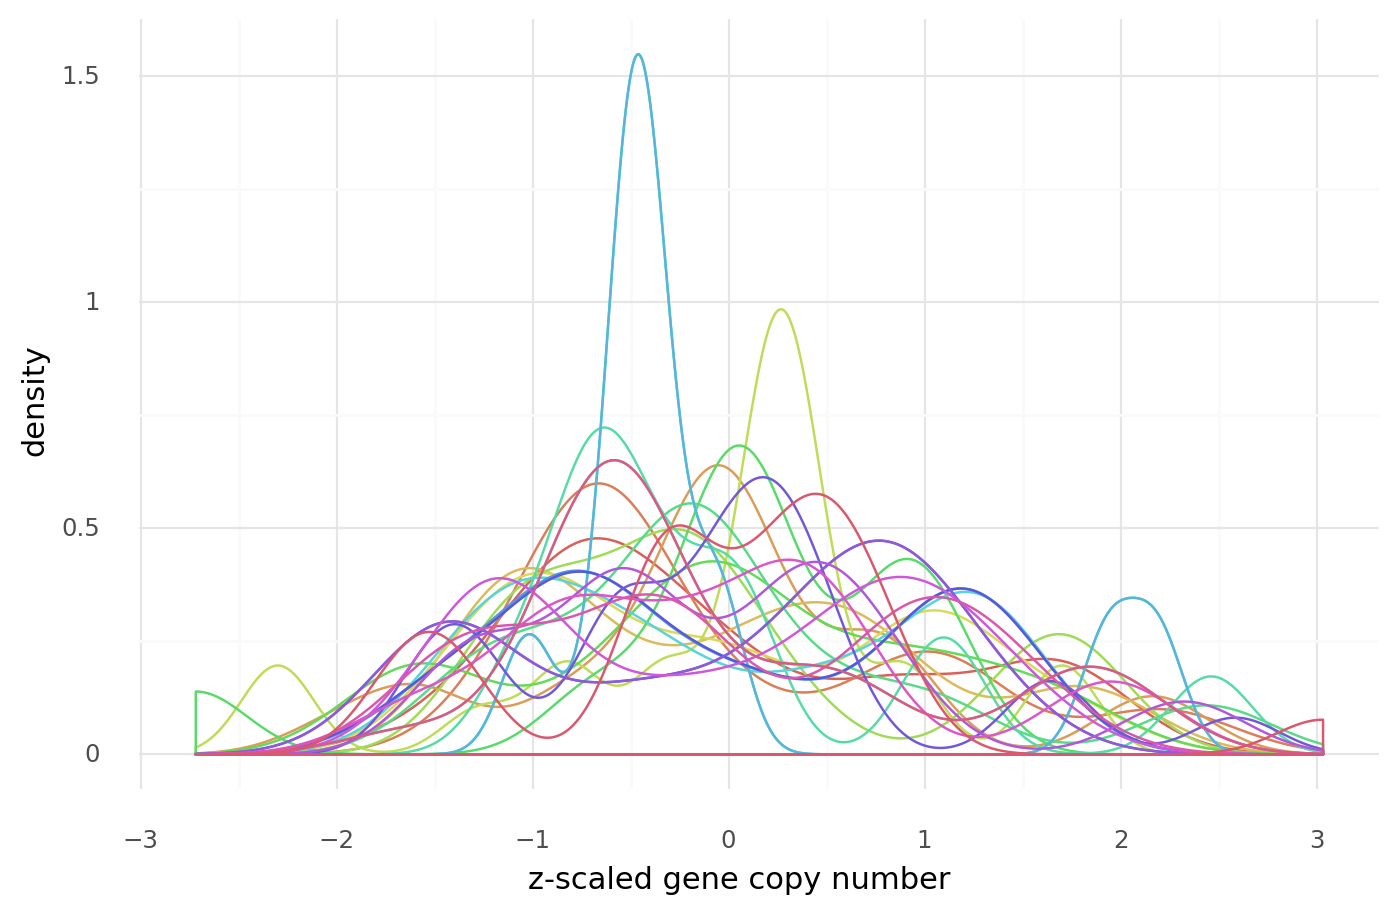

<ggplot: (8784022179045)>

In [8]:
(
    gg.ggplot(data, gg.aes(x="gene_cn_z"))
    + gg.geom_density(gg.aes(color="hugo_symbol"), size=0.5)
    + gg.scale_color_discrete(guide=False)
    + gg.theme(figure_size=(8, 5))
    + gg.labs(x="z-scaled gene copy number", y="density")
)

## Modeling

### Model 1.

Below is the model that will be fit with PyMC3 as the mimic of CERES without any covariate for the gene CN.

$
\quad D_{ij} \sim \mathcal{N}(\mu_{ij}, \epsilon) \\
\quad \mu_{ij} = q_i \lgroup h_k + g_{kj} \rgroup + o_i \\
\qquad q_i \sim \text{Beta}(2, 2) \\
\qquad h_k \sim \mathcal{N}(0, 1) \\
\qquad g_{kj} \sim \mathcal{N}(0, 1) \\
\qquad o_i \sim \mathcal{N}(0, 1) \\
\quad \epsilon \sim \text{Exp}(1)
$

In [9]:
with pm.Model() as ceres_m1:
    # Priors
    q_i = pm.Beta("q_i", alpha=2, beta=2, shape=num_sgrnas)
    h_k = pm.Normal("h_k", 0, 1, shape=num_genes)
    g_kj = pm.Normal("g_kj", 0, 2, shape=(num_genes, num_cell_lines))
    o_i = pm.Normal("o_i", 0, 1, shape=num_sgrnas)

    # Model
    mu_ij = pm.Deterministic(
        "mu",
        q_i[sgrna_idx] * (h_k[gene_idx] + g_kj[gene_idx, cell_line_idx])
        + o_i[sgrna_idx],
    )
    epsilon = pm.Exponential("epsilon", 1)

    # Likelihood
    D_ij = pm.Normal("D_ij", mu_ij, epsilon, observed=data.lfc)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


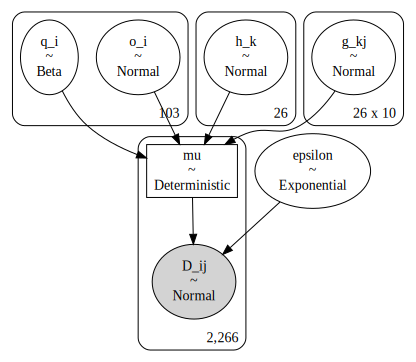

In [10]:
pm.model_to_graphviz(ceres_m1)

In [32]:
%%time

ceres_m1_cachedir = pymc3_cache_dir / "ceres_m1"

ceres_m1_samples = pmhelp.pymc3_sampling_procedure(
    model=ceres_m1,
    num_mcmc=3000,
    tune=1500,
    chains=3,
    prior_check_samples=1000,
    ppc_samples=2000,
    random_seed=RANDOM_SEED,
    cache_dir=ceres_m1_cachedir,
    force=False,
)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [epsilon, o_i, g_kj, h_k, q_i]


Sampling 3 chains for 1_500 tune and 3_000 draw iterations (4_500 + 9_000 draws total) took 325 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Caching trace and posterior sample...
CPU times: user 28.9 s, sys: 3.5 s, total: 32.4 s
Wall time: 5min 47s


In [33]:
az_ceres_m1 = az.from_pymc3(
    trace=ceres_m1_samples["trace"],
    model=ceres_m1,
    prior=ceres_m1_samples["prior_predictive"],
    posterior_predictive=ceres_m1_samples["posterior_predictive"],
)

arviz.data.io_pymc3 - WARNING - posterior predictive variable D_ij's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


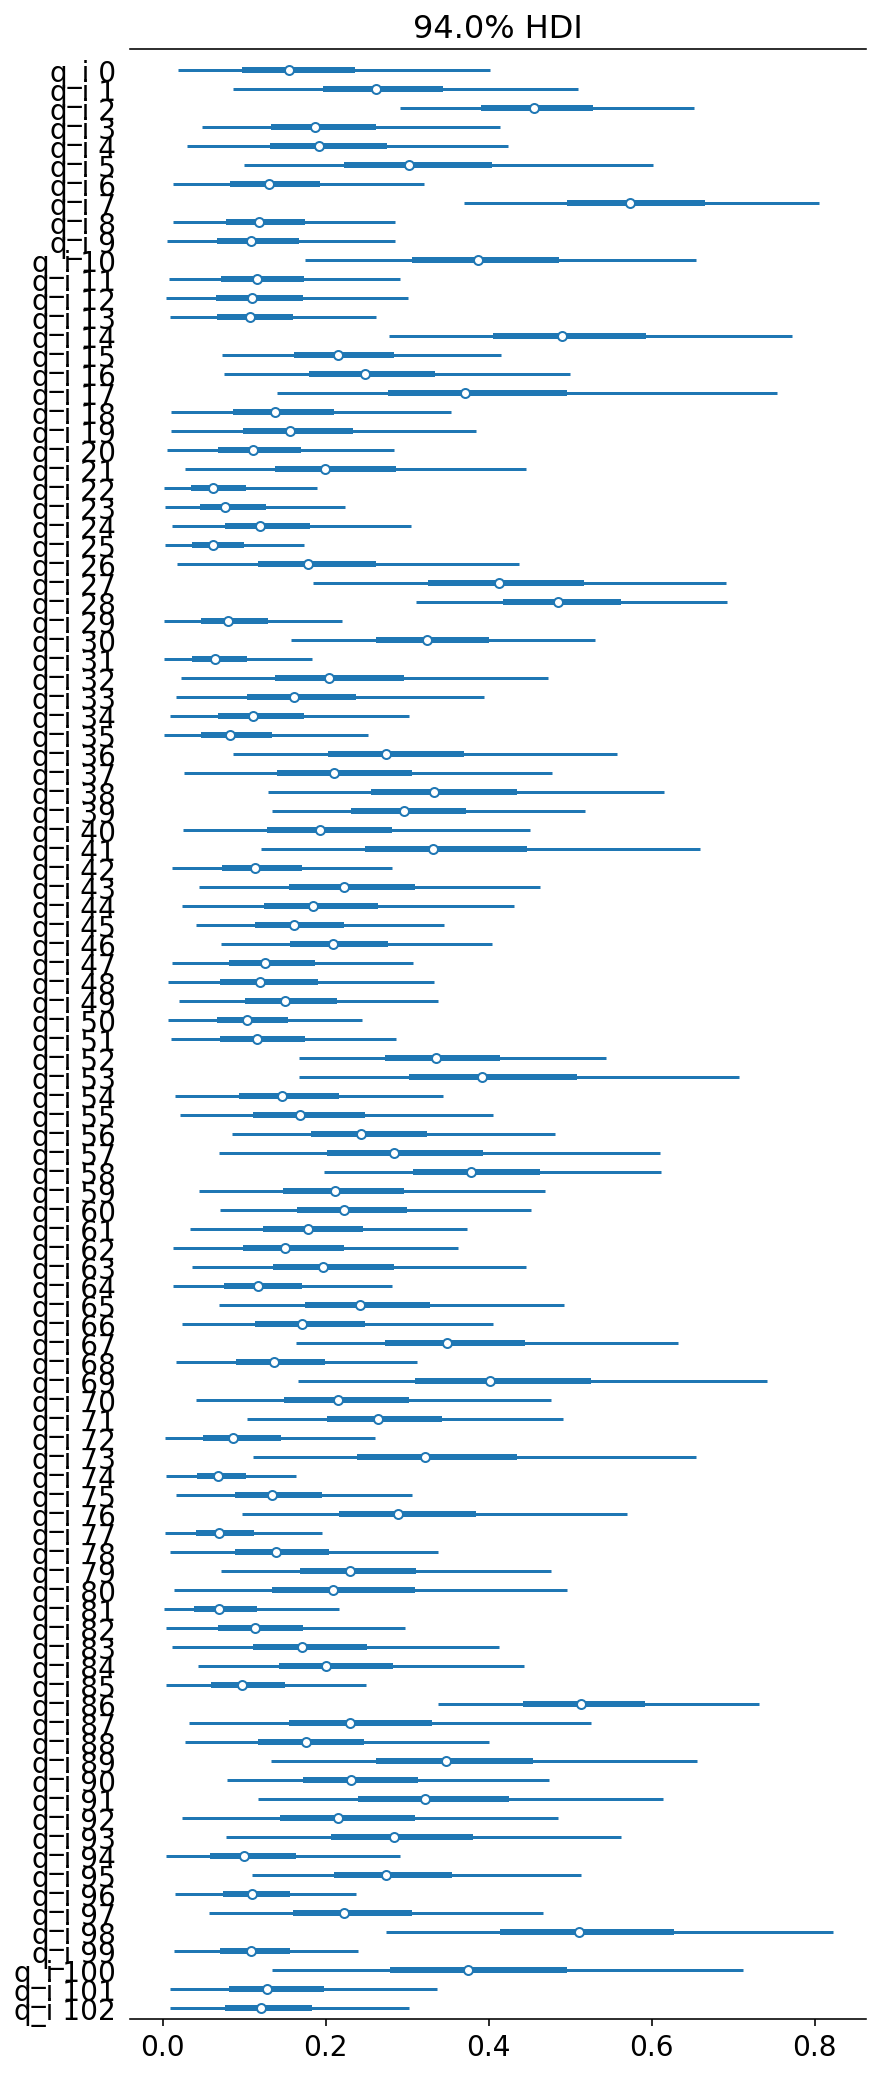

In [34]:
az.plot_forest(az_ceres_m1, var_names="q_i", combined=True)
plt.show()

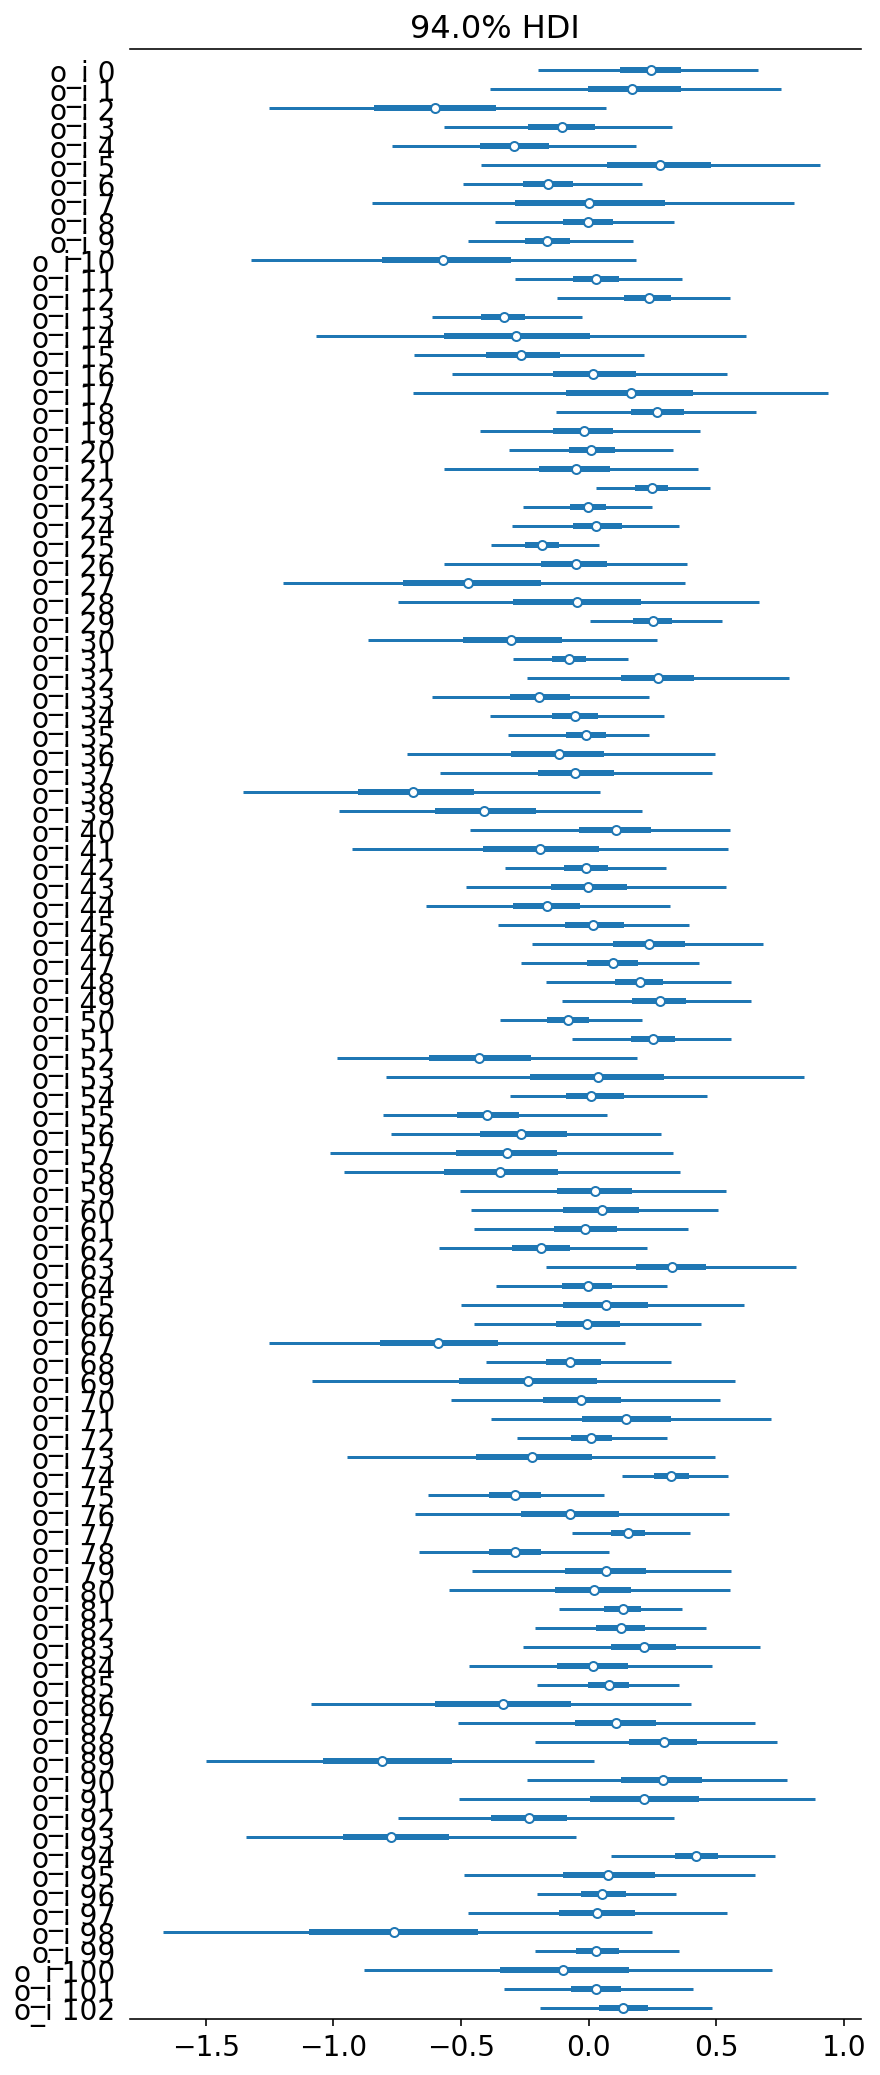

In [35]:
az.plot_forest(az_ceres_m1, var_names="o_i", combined=True)
plt.show()

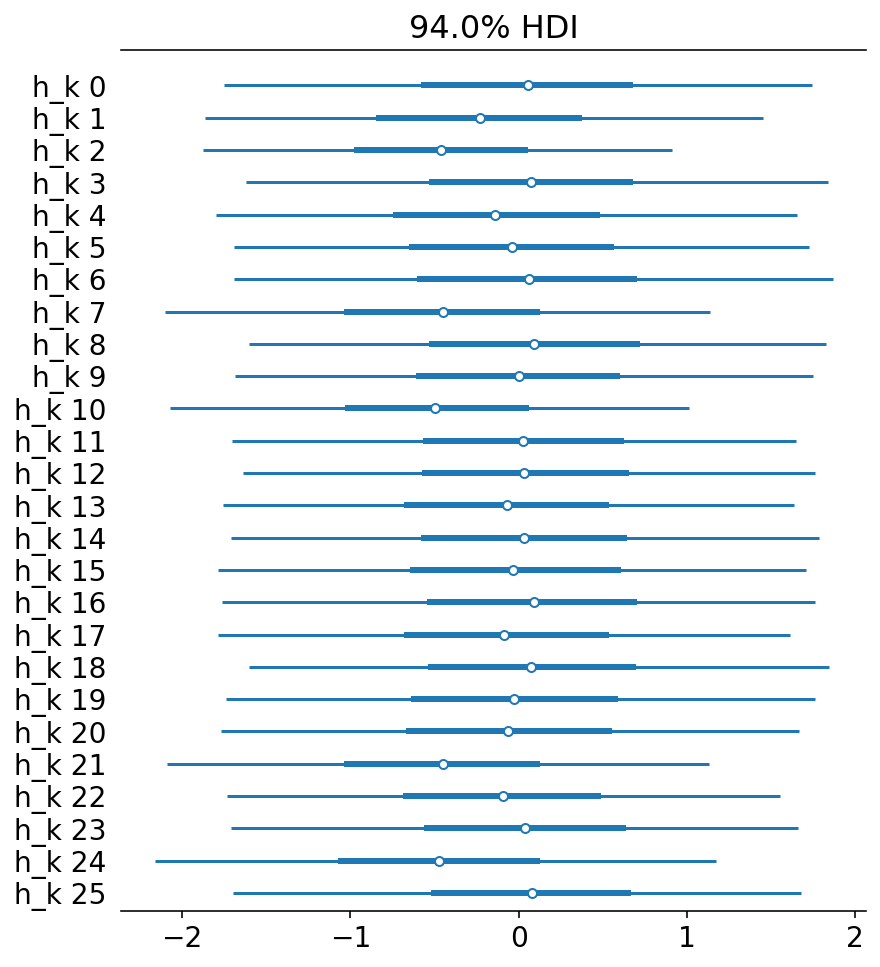

In [36]:
az.plot_forest(az_ceres_m1, var_names="h_k", combined=True)
plt.show()

In [37]:
gene_effect_post = ceres_m1_samples["trace"].get_values("g_kj")
gene_effect_post.shape

(9000, 26, 10)

In [38]:
gene_effect_mean = gene_effect_post.mean(axis=0)
gene_effect_mean.shape

(26, 10)

In [39]:
gene_effect_post_df = (
    pd.DataFrame(gene_effect_mean)
    .reset_index()
    .rename(columns={"index": "gene_idx"})
    .melt(id_vars="gene_idx", var_name="cell_line_idx", value_name="gene_effect")
    .assign(
        hugo_symbol=lambda d: [
            data["hugo_symbol"].values.categories[i] for i in d["gene_idx"].values
        ],
        depmap_id=lambda d: [
            data["depmap_id"].values.categories[i] for i in d["cell_line_idx"].values
        ],
    )
)

cols = ["depmap_id", "kras_mutation", "is_deleterious"]
mutation_info = data[cols].drop_duplicates()
mutation_info[cols[:-1]] = mutation_info[cols[:-1]].astype("str")

gene_effect_post_df = gene_effect_post_df.merge(
    mutation_info, how="left", on=["depmap_id"]
)

gene_effect_post_df.head(n=7)

,gene_idx,cell_line_idx,gene_effect,hugo_symbol,depmap_id,kras_mutation,is_deleterious
0,0,0,-0.721432,PDE5A,ACH-000535,WT,NaN
1,0,0,-0.721432,PDE5A,ACH-000535,WT,FALSE
2,1,0,0.393648,TP53,ACH-000535,WT,NaN
3,1,0,0.393648,TP53,ACH-000535,WT,FALSE
4,2,0,0.552273,KRAS,ACH-000535,WT,NaN
5,2,0,0.552273,KRAS,ACH-000535,WT,FALSE
6,3,0,0.417423,KIF3C,ACH-000535,WT,NaN


In [40]:
data.is_deleterious.unique()

array([nan, 'FALSE', 'TRUE', 'FALSE;FALSE'], dtype=object)

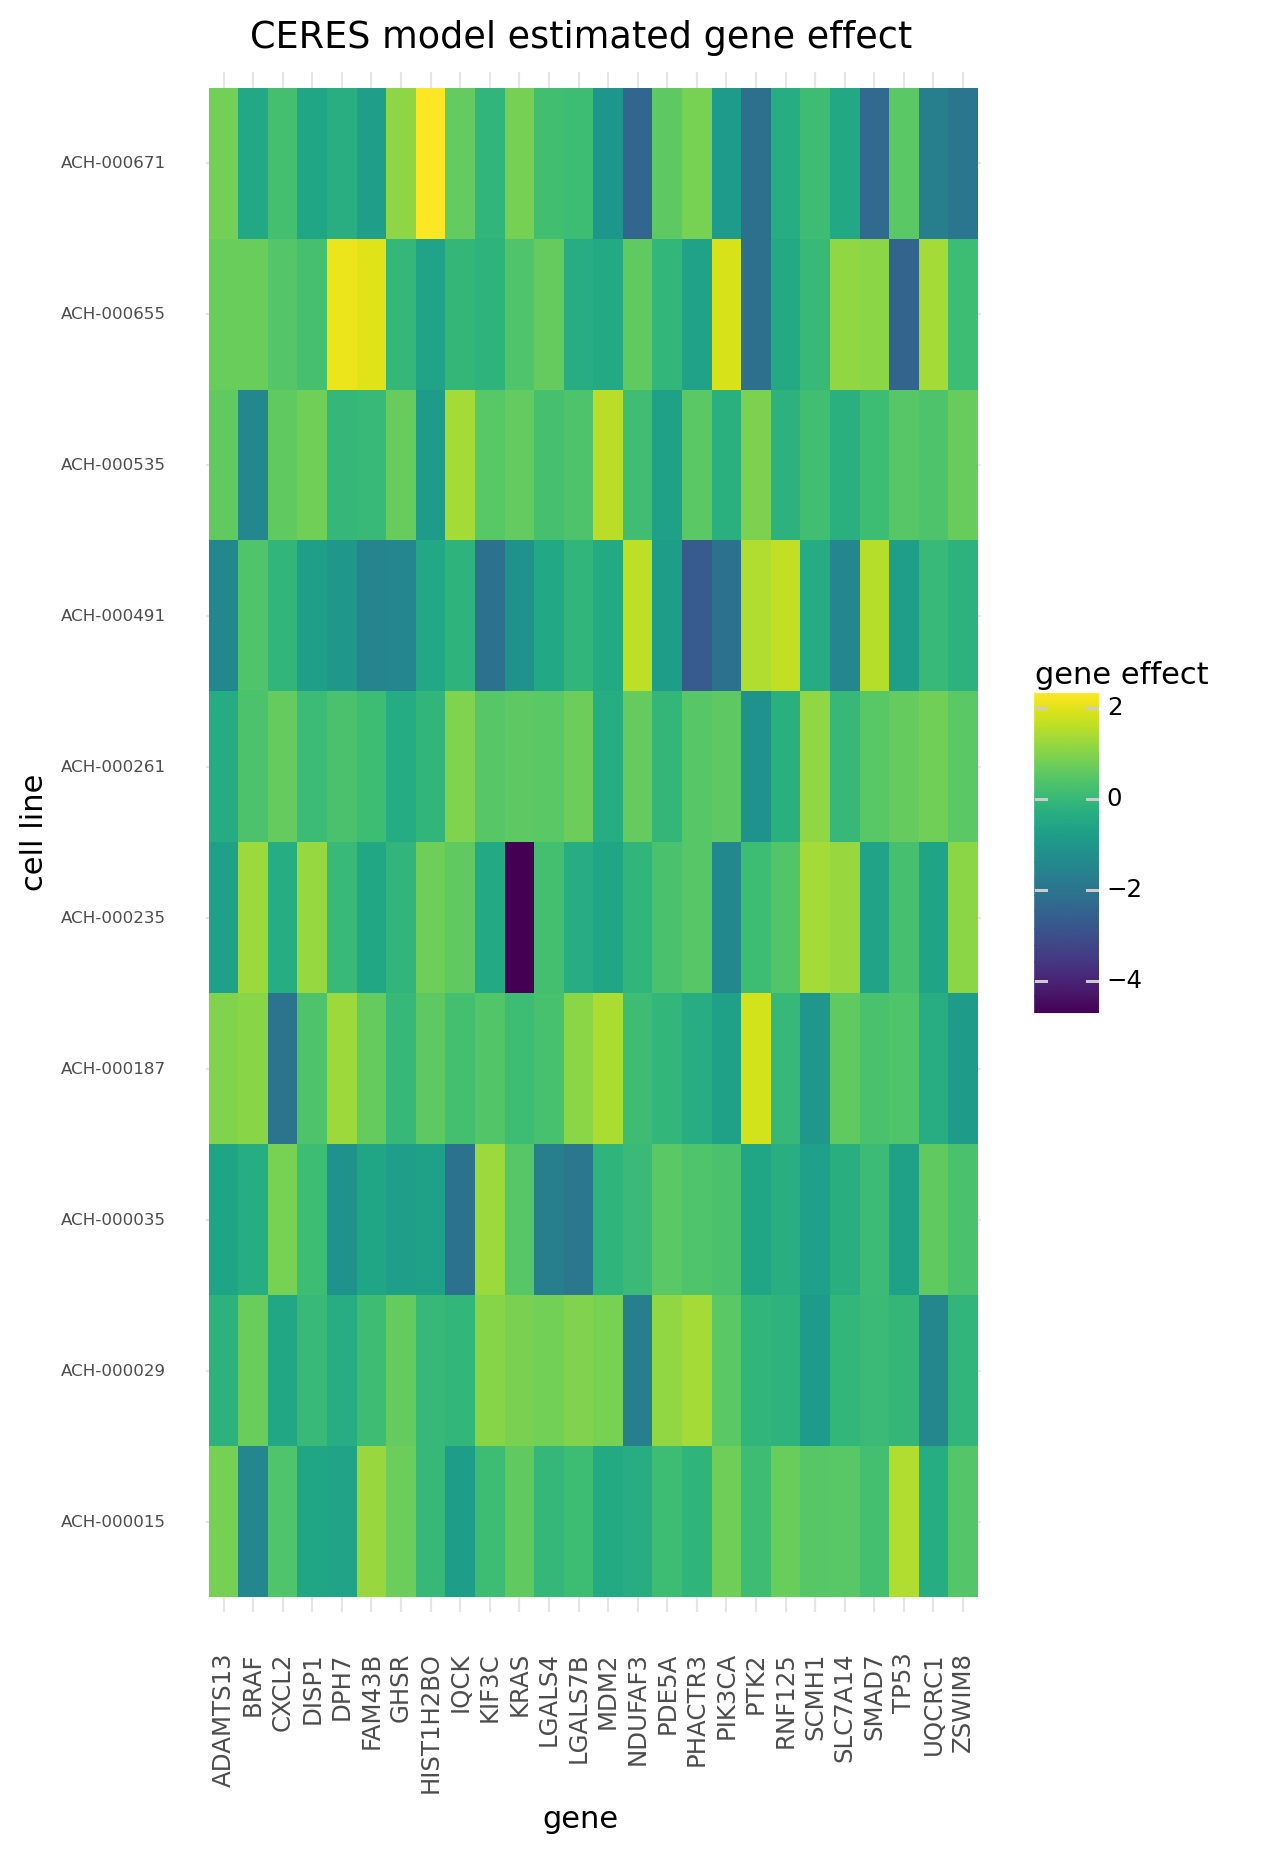

<ggplot: (8783961159358)>

In [41]:
(
    gg.ggplot(gene_effect_post_df, gg.aes(x="hugo_symbol", y="depmap_id"))
    + gg.geom_tile(gg.aes(fill="gene_effect"))
    + gg.theme(
        figure_size=(5, 10),
        axis_text_x=gg.element_text(angle=90),
        axis_text_y=gg.element_text(size=6),
    )
    + gg.labs(
        x="gene",
        y="cell line",
        fill="gene effect",
        title="CERES model estimated gene effect",
    )
)

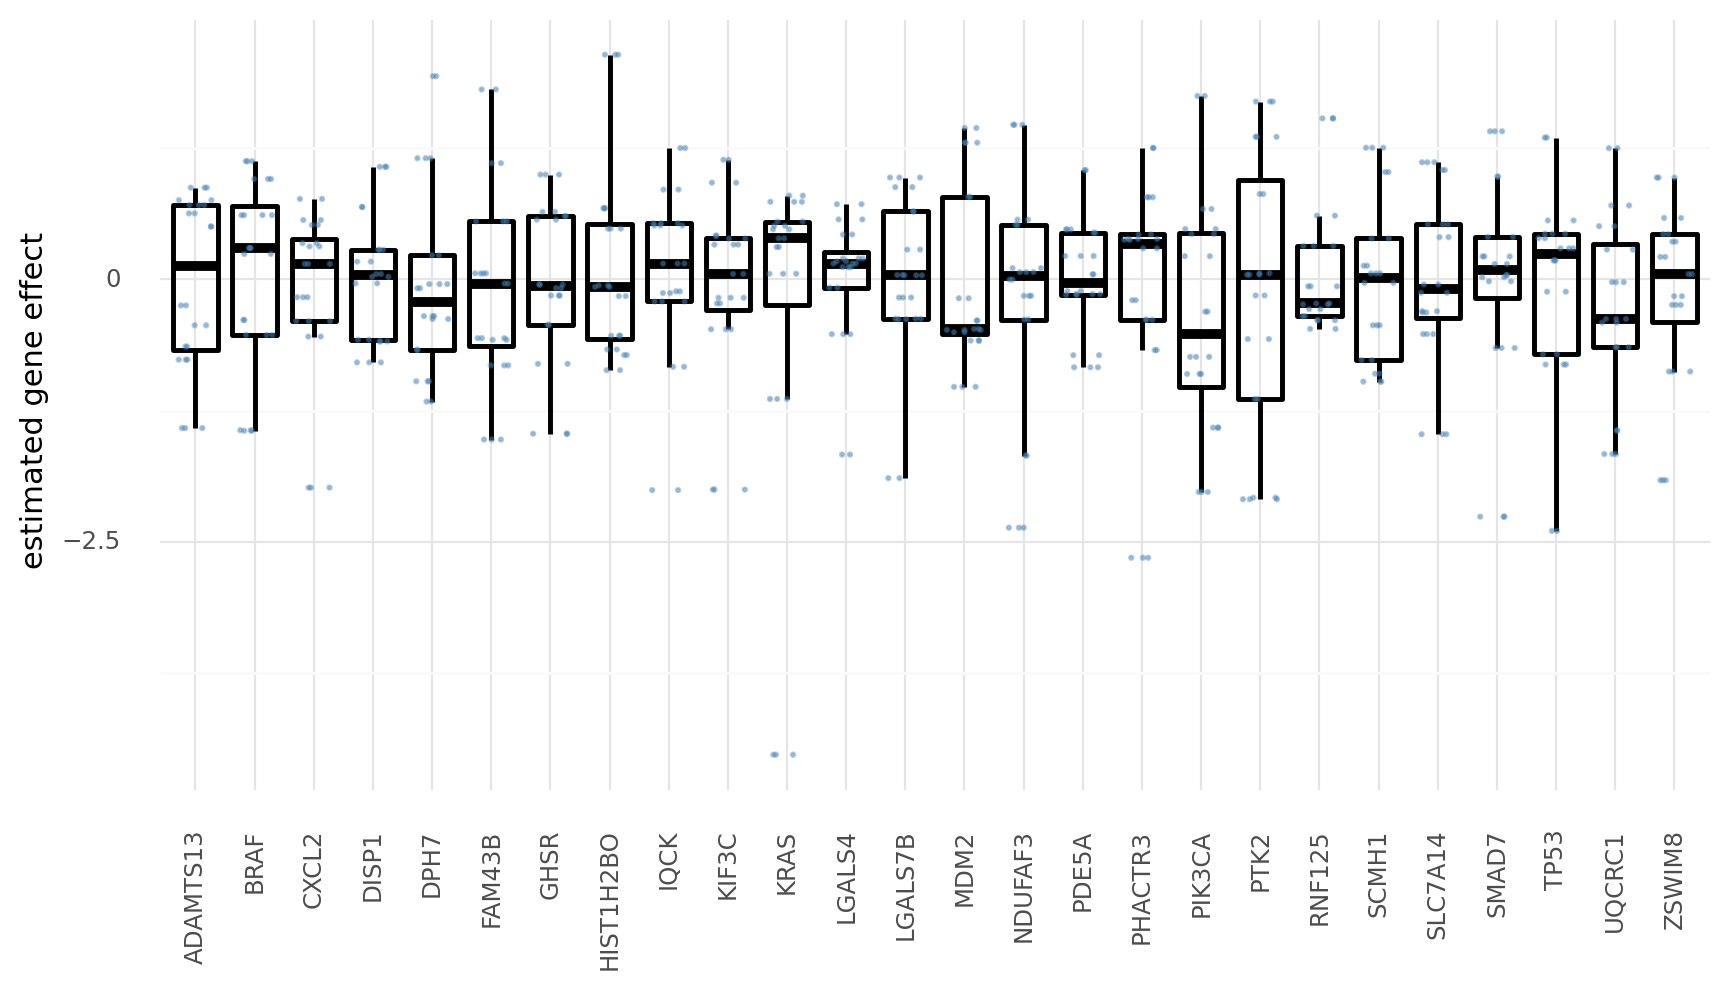

<ggplot: (8783795051307)>

In [42]:
(
    gg.ggplot(gene_effect_post_df, gg.aes(x="hugo_symbol", y="gene_effect"))
    + gg.geom_boxplot(alpha=0, color="black", outlier_alpha=0, size=1)
    + gg.geom_jitter(alpha=0.4, size=0.3, height=0, width=0.3, color="steelblue")
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1), figure_size=(10, 5)
    )
    + gg.labs(x=None, y="estimated gene effect")
)

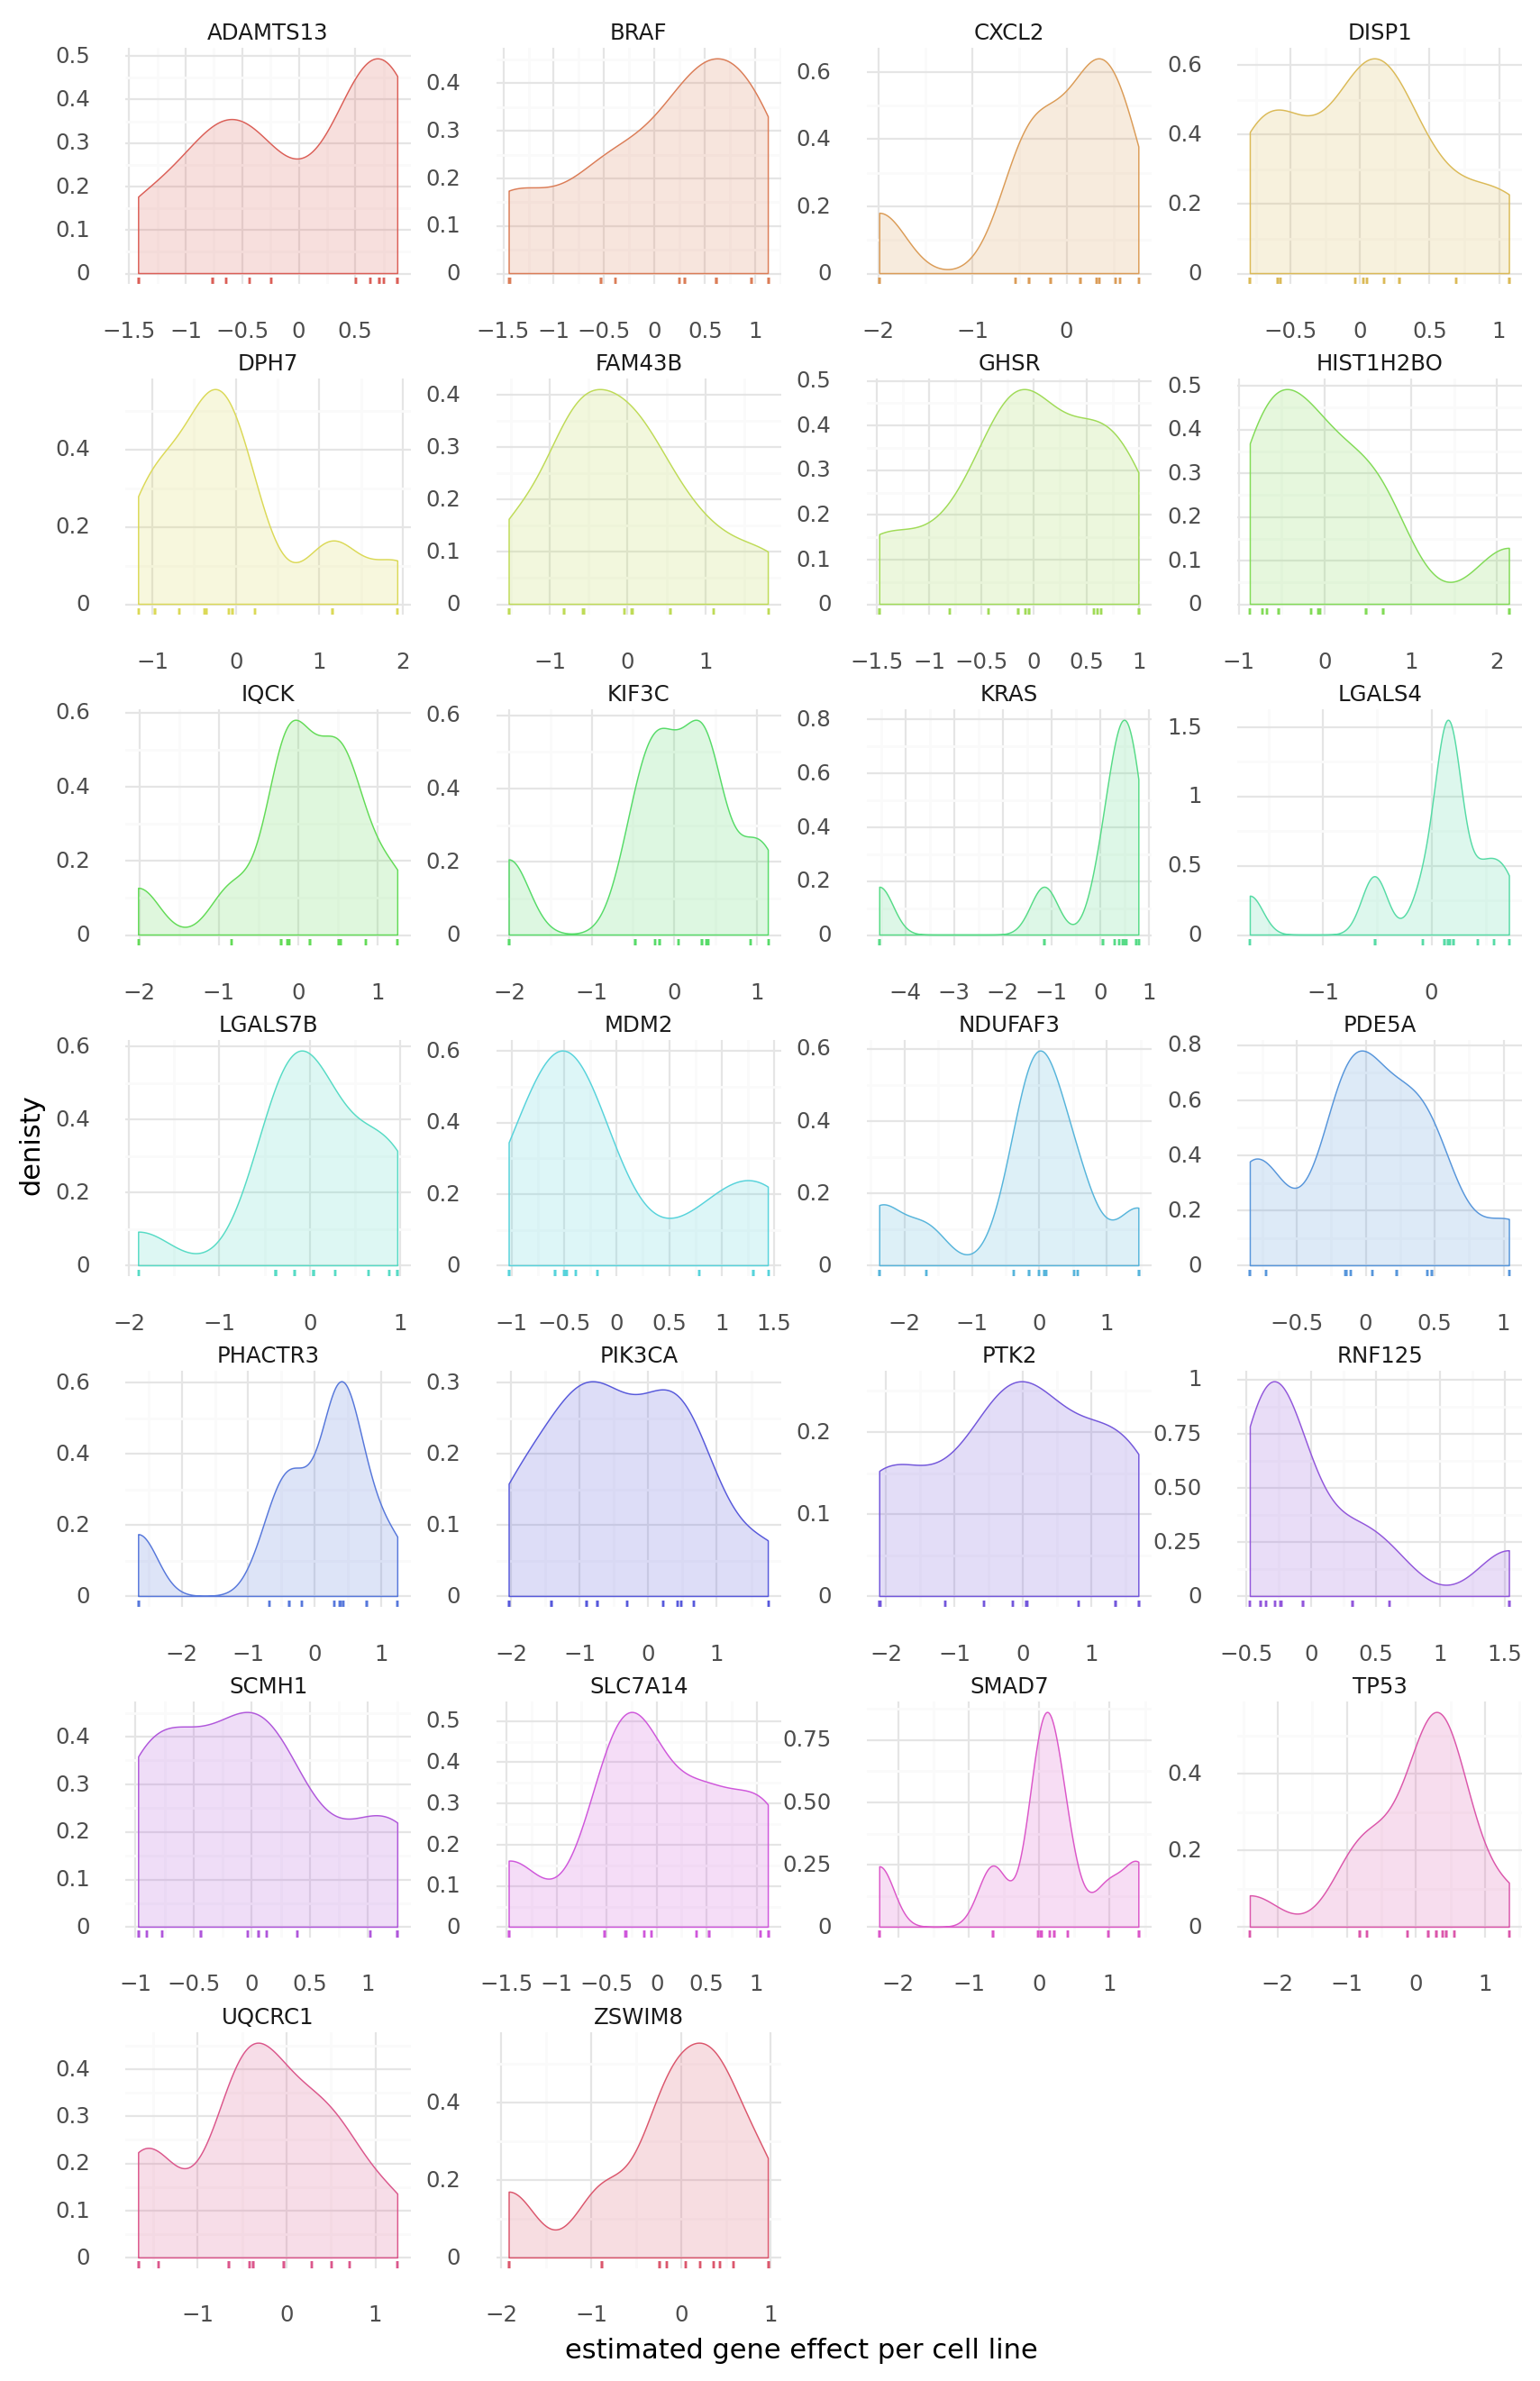

<ggplot: (8783797962861)>

In [43]:
(
    gg.ggplot(gene_effect_post_df, gg.aes(x="gene_effect"))
    + gg.facet_wrap("hugo_symbol", ncol=4, scales="free")
    + gg.geom_density(
        gg.aes(color="hugo_symbol", fill="hugo_symbol"), alpha=0.2, size=0.3
    )
    + gg.geom_rug(gg.aes(color="hugo_symbol"))
    + gg.theme(
        figure_size=(10, 16),
        legend_position="none",
        subplots_adjust={"hspace": 0.4, "wspace": 0.3},
    )
    + gg.labs(x="estimated gene effect per cell line", y="denisty")
)

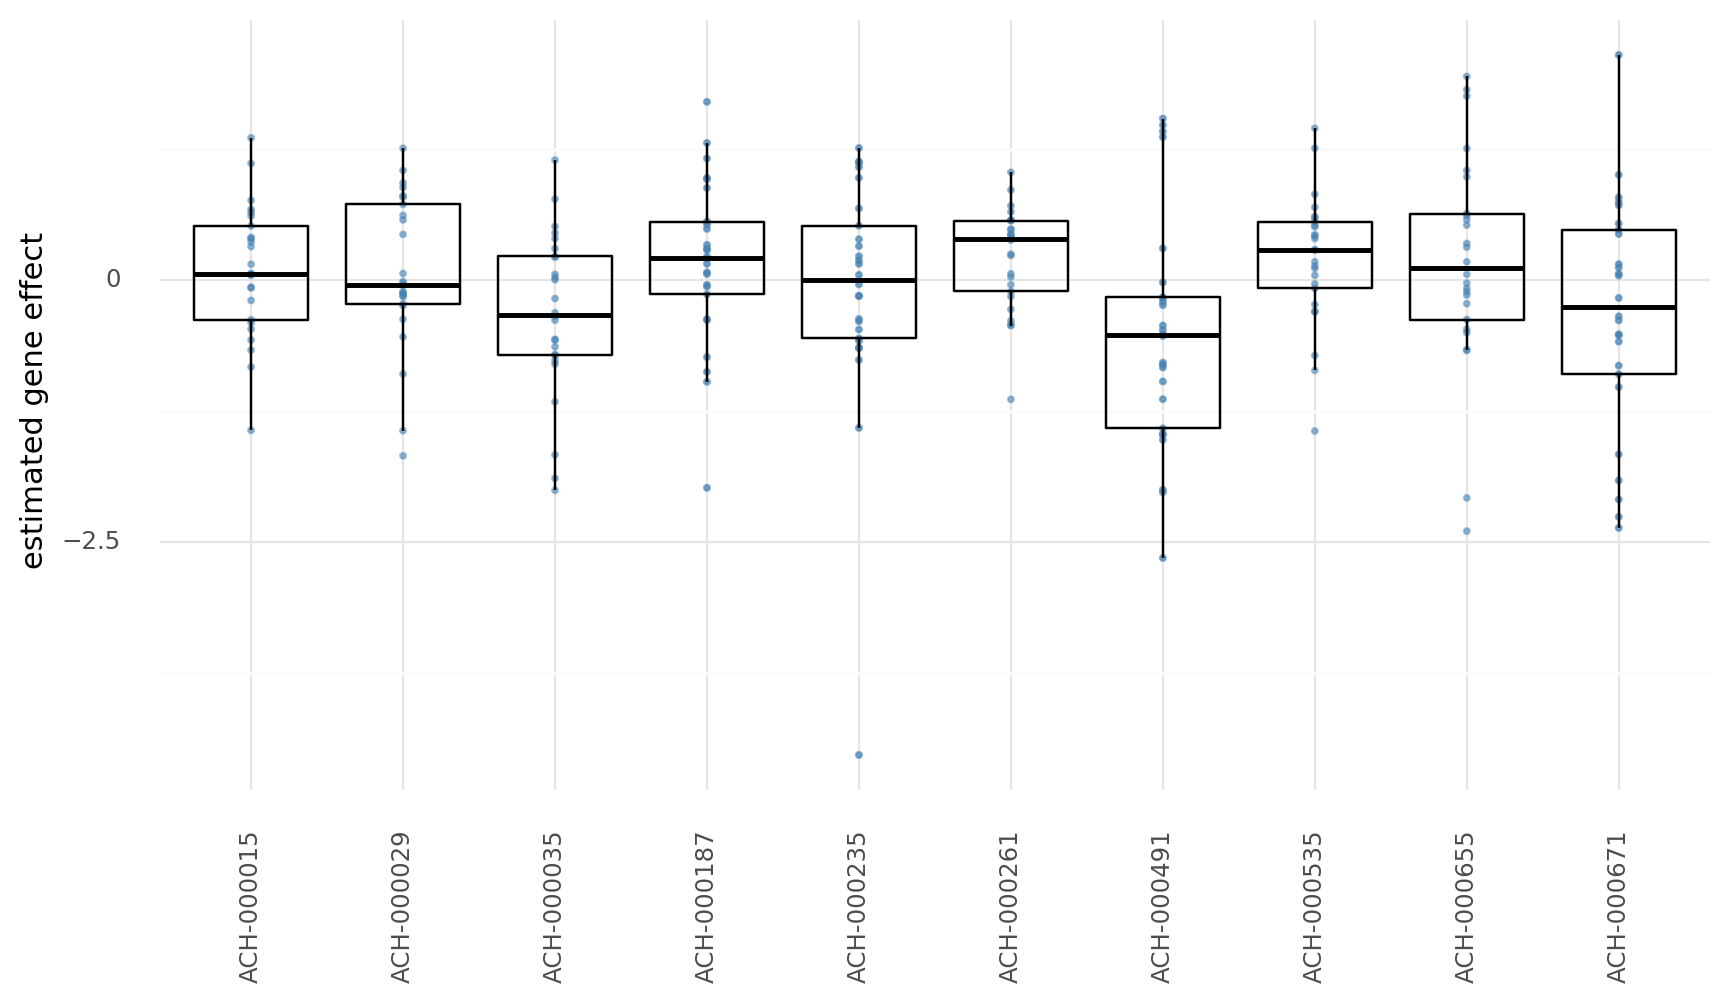

<ggplot: (8783798109793)>

In [44]:
(
    gg.ggplot(gene_effect_post_df, gg.aes(x="depmap_id", y="gene_effect"))
    + gg.geom_jitter(alpha=0.3, size=0.6, height=0, width=0, color="steelblue")
    + gg.geom_boxplot(alpha=0, color="black", outlier_alpha=0)
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1), figure_size=(10, 5)
    )
    + gg.labs(x=None, y="estimated gene effect")
)

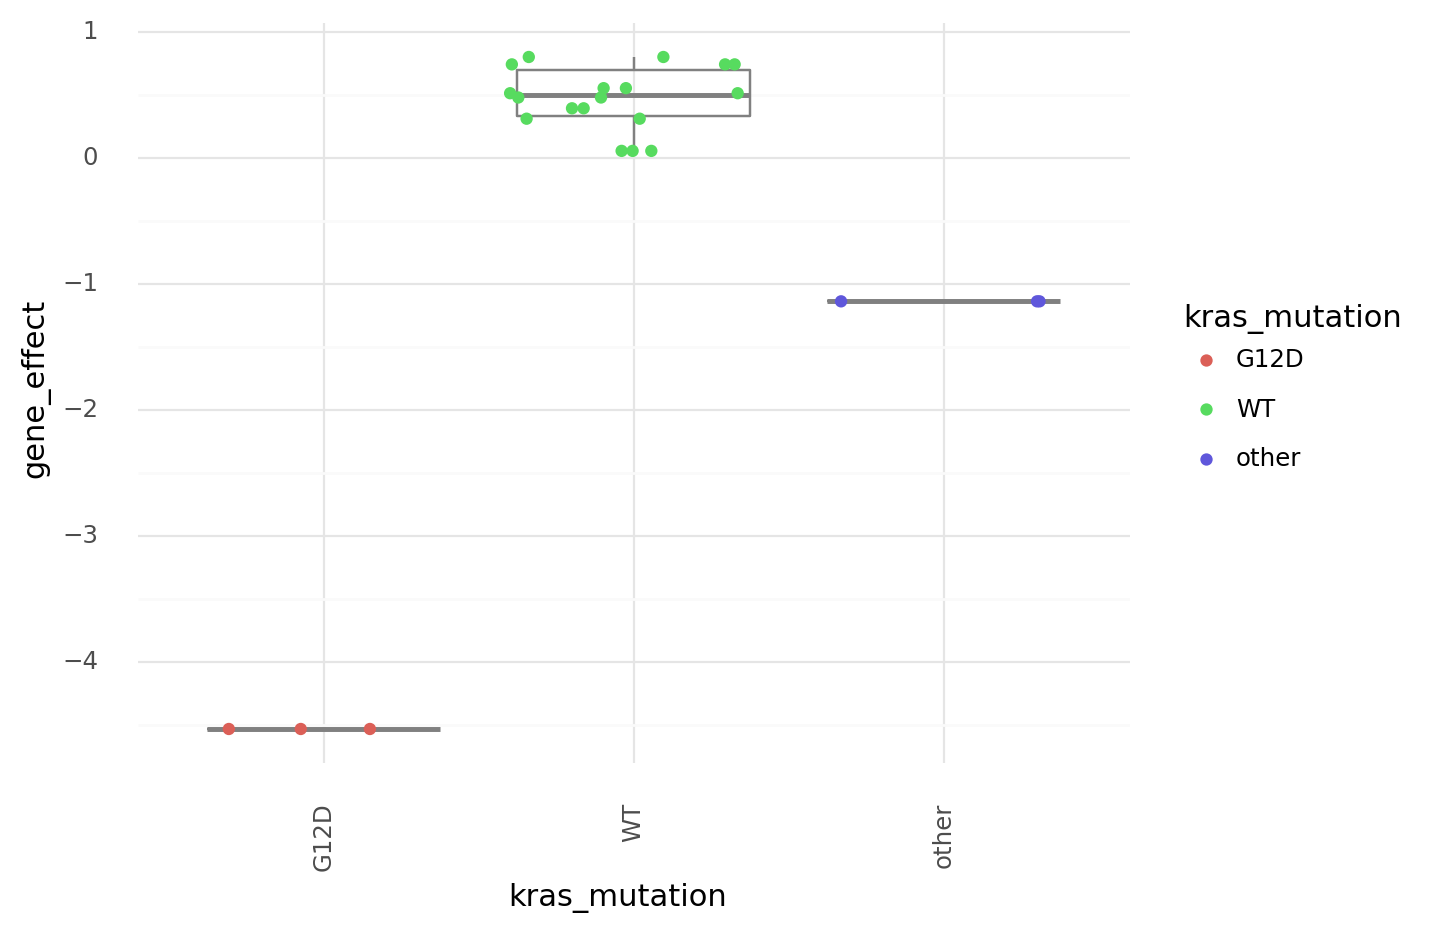

<ggplot: (8783798223583)>

In [45]:
kras_gene_effect = gene_effect_post_df[
    gene_effect_post_df.hugo_symbol == "KRAS"
].reset_index(drop=True)

(
    gg.ggplot(kras_gene_effect, gg.aes(x="kras_mutation", y="gene_effect"))
    + gg.geom_boxplot(alpha=0, color="gray", outlier_alpha=0)
    + gg.geom_jitter(gg.aes(color="kras_mutation"), width=0.4, height=0)
    + gg.theme(axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1))
)

---

### Model 2.

Below is the model that will be fit with PyMC3 as the mimic of CERES with a covariate for the gene CN modeled as a standard linear coefficient.
The copy number values were z-scaled within each gene.

$
\quad D_{ij} \sim \mathcal{N}(\mu_{ij}, \epsilon) \\
\quad \mu_{ij} = q_i \lgroup h_k + g_{kj} + \beta_{ij} C \rgroup + o_i \\
\qquad q_i \sim \text{Beta}(2, 2) \\
\qquad h_k \sim \mathcal{N}(0, 1) \\
\qquad g_{kj} \sim \mathcal{N}(0, 1) \\
\qquad o_i \sim \mathcal{N}(0, 1) \\
\quad \epsilon \sim \text{Exp}(1)
$

In [46]:
BATCH_SIZE = 100
sgrna_idx_mb = pm.Minibatch(sgrna_idx, batch_size=BATCH_SIZE)
gene_idx_mb = pm.Minibatch(gene_idx, batch_size=BATCH_SIZE)
cell_line_idx_mb = pm.Minibatch(cell_line_idx, batch_size=BATCH_SIZE)

gene_cn_z_mb = pm.Minibatch(data.gene_cn_z.to_numpy(), batch_size=BATCH_SIZE)
lfc_mb = pm.Minibatch(data.lfc.to_numpy(), batch_size=BATCH_SIZE)

with pm.Model() as ceres_m2:
    # Priors
    q_i = pm.Beta("q_i", alpha=2, beta=2, shape=num_sgrnas)
    h_k = pm.Normal("h_k", 0, 1, shape=num_genes)
    g_kj = pm.Normal("g_kj", 0, 2, shape=(num_genes, num_cell_lines))
    beta_ij = pm.Normal("beta_ij", -0.5, 1, shape=(num_sgrnas, num_cell_lines))
    o_i = pm.Normal("o_i", 0, 1, shape=num_sgrnas)

    # Model
    mu_ij = pm.Deterministic(
        "mu",
        q_i[sgrna_idx_mb]
        * (
            h_k[gene_idx_mb]
            + g_kj[gene_idx_mb, cell_line_idx_mb]
            + beta_ij[sgrna_idx_mb, cell_line_idx_mb] * gene_cn_z_mb
        )
        + o_i[sgrna_idx_mb],
    )
    epsilon = pm.Exponential("epsilon", 1)

    # Likelihood
    D_ij = pm.Normal("D_ij", mu_ij, epsilon, observed=lfc_mb, total_size=len(data))

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/pymc3/data.py:307: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/pymc3/data.py:307: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(s

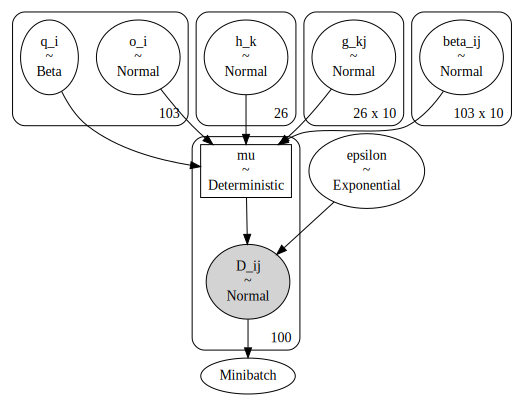

In [47]:
pm.model_to_graphviz(ceres_m2)

In [48]:
%%time

with ceres_m2:
    ceres_m2_advi_meanfield = pm.fit(
        40000,
        method="advi",
        callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)],
    )

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Finished [100%]: Average Loss = 110.98


CPU times: user 32.6 s, sys: 949 ms, total: 33.6 s
Wall time: 40 s


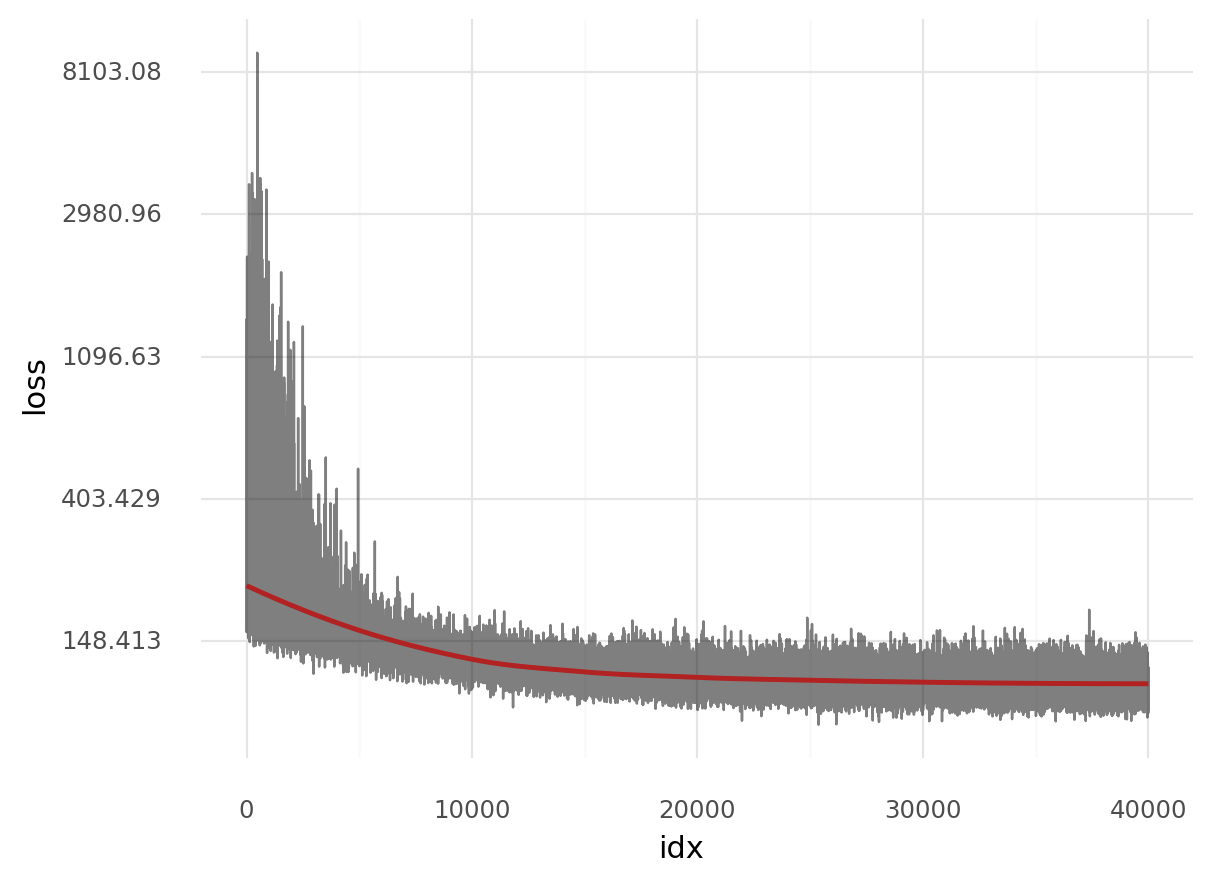

<ggplot: (8783948656153)>

In [49]:
df = pd.DataFrame(
    {
        "loss": ceres_m2_advi_meanfield.hist,
        "idx": range(len(ceres_m2_advi_meanfield.hist)),
    }
)
(
    gg.ggplot(df, gg.aes(x="idx", y="loss"))
    + gg.geom_line(group="a", color="black", alpha=0.5)
    + gg.geom_smooth(method="loess", se=False, color="firebrick")
    + gg.scale_y_continuous(trans="log")
)

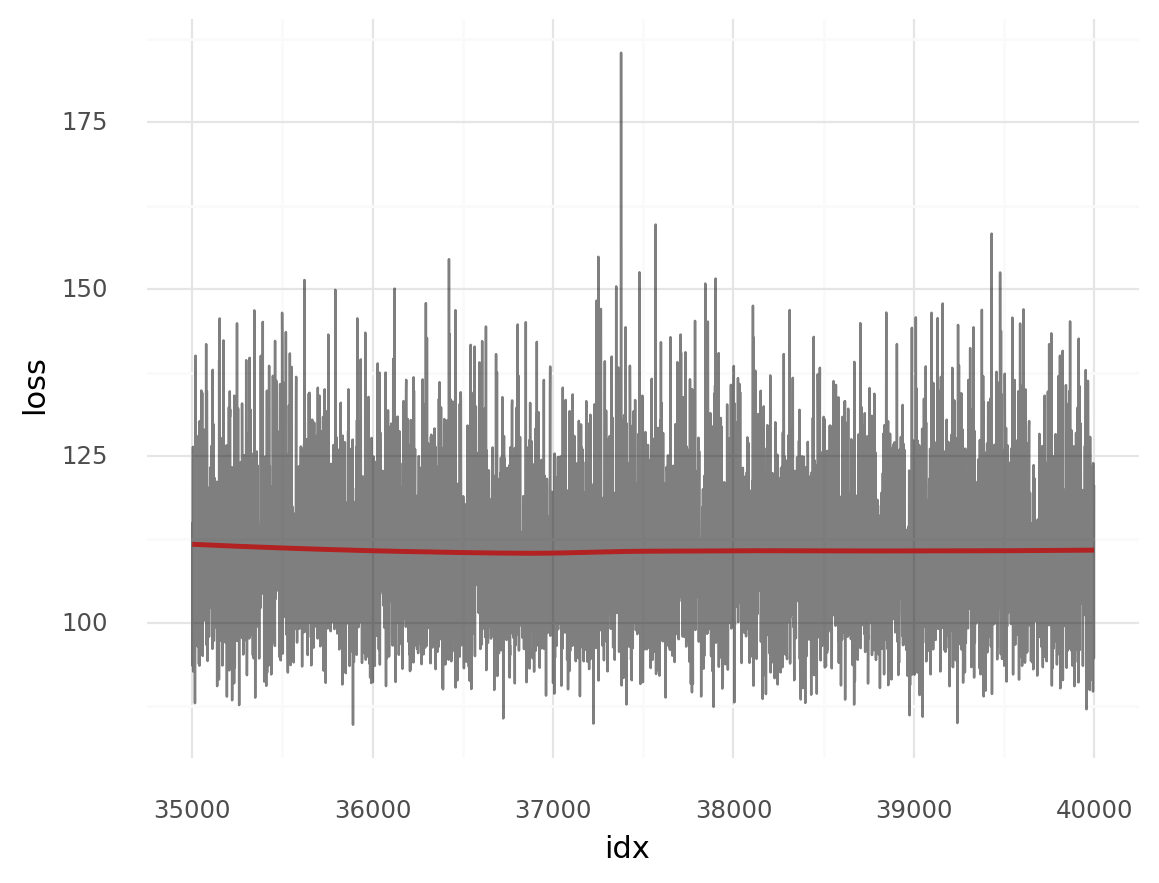

<ggplot: (8783948656948)>

In [50]:
(
    gg.ggplot(df.tail(n=5000), gg.aes(x="idx", y="loss"))
    + gg.geom_line(group="a", color="black", alpha=0.5)
    + gg.geom_smooth(method="loess", se=False, color="firebrick")
)

In [51]:
with pm.Model() as ceres_m2_full:
    # Priors
    q_i = pm.Beta("q_i", alpha=2, beta=2, shape=num_sgrnas)
    h_k = pm.Normal("h_k", 0, 1, shape=num_genes)
    g_kj = pm.Normal("g_kj", 0, 2, shape=(num_genes, num_cell_lines))
    beta_ij = pm.Normal("beta_ij", -0.5, 1, shape=(num_sgrnas, num_cell_lines))
    o_i = pm.Normal("o_i", 0, 1, shape=num_sgrnas)

    # Model
    mu_ij = pm.Deterministic(
        "mu",
        q_i[sgrna_idx]
        * (
            h_k[gene_idx]
            + g_kj[gene_idx, cell_line_idx]
            + beta_ij[sgrna_idx, cell_line_idx] * data.gene_cn_z.values
        )
        + o_i[sgrna_idx],
    )
    epsilon = pm.Exponential("epsilon", 1)

    # Likelihood
    D_ij = pm.Normal("D_ij", mu_ij, epsilon, observed=data.lfc.values)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [53]:
%%time
with ceres_m2_full:
    ceres_m2_trace = pm.sample(2000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, o_i, beta_ij, g_kj, h_k, q_i]
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 209 seconds.
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


CPU times: user 25.7 s, sys: 2.11 s, total: 27.9 s
Wall time: 3min 43s


In [65]:
%%time
with ceres_m2_full:
    #     step = pm.NUTS(scaling=ceres_m2_advi_meanfield.cov.eval(), is_cov=True)
    ceres_m2_trace_advi = pm.sample(
        2000,
        init="advi",
        n_init=40000,
        tune=2000,
        progressbar=True,
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 1,460
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, o_i, beta_ij, g_kj, h_k, q_i]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 268 seconds.
The number of effective samples is smaller than 10% for some parameters.


CPU times: user 1min 10s, sys: 2.63 s, total: 1min 12s
Wall time: 5min 28s


todo

- compare the results of using ADVI initialization
- compare ADVI samples to MCMC
- figure out why the MCMC refuses to start with too many parameters

In [62]:
# %%time

# ceres_m2_cachedir = pymc3_cache_dir / "ceres_m2"

# ceres_m2_samples = pmhelp.pymc3_sampling_procedure(
#     model=ceres_m2,
#     num_mcmc=3000,
#     tune=1500,
#     chains=3,
#     prior_check_samples=1000,
#     ppc_samples=2000,
#     random_seed=RANDOM_SEED,
#     cache_dir=ceres_m2_cachedir,
#     force=False,
# )

In [63]:
# az_ceres_m2 = az.from_pymc3(
#     trace=ceres_m2_samples["trace"],
#     model=ceres_m2,
#     prior=ceres_m2_samples["prior_predictive"],
#     posterior_predictive=ceres_m2_samples["posterior_predictive"],
# )